# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os
from torch.utils.data import DataLoader
import torchvision

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    num_workers = 0
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 32x32
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + data_dir
    #train_path = os.path.join(image_path, "celeba")
    train_path = image_path

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_loader
    


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128 # just like DCGAN exercise, power of 2
img_size = 32 # the requirement

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

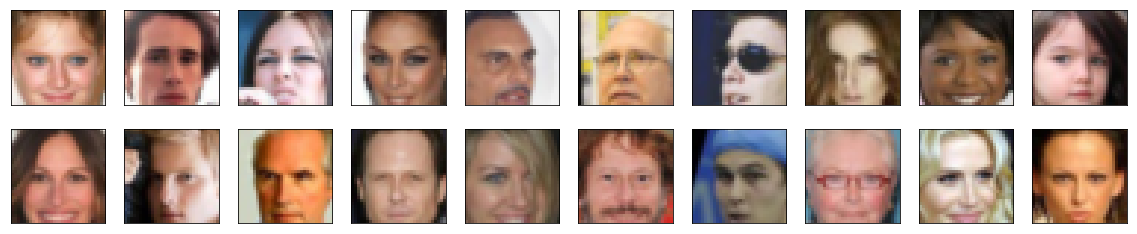

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max - min) + min
    
    return x



In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9216)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:


# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        #32X32 input
        #the first layer, no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False) #x, y = 32, depth 32
        #out 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4) #(16, 16, 64)
        #out 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) #(8, 8, 128)
        #out 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) #(4, 4, 256)
        #out 2 x 2
        #last layer, linear fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers +  relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # flatten
        #out = out.view(-1, self.conv_dim*8)
        out = out.view(-1, self.conv_dim*8*2*2)
        
        
        # final output layer
        # last, classification layer
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


In [11]:
!pip install pytorch-model-summary 

In [12]:
from pytorch_model_summary import summary
              # show input shape
print(summary(Discriminator(32), torch.zeros((50, 3, 32, 32)), show_input=True))
              # show output shape
print(summary(Discriminator(32), torch.zeros((50, 3, 32, 32)), show_input=False))
              # show output shape and hierarchical view of net
print(summary(Discriminator(32), torch.zeros((50, 3, 32, 32)), show_input=False, show_hierarchical=True))
              #torch.zeros((batch_size, depth, height, width))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1      [50, 3, 32, 32]           1,536           1,536
          Conv2d-2     [50, 32, 16, 16]          32,768          32,768
     BatchNorm2d-3       [50, 64, 8, 8]             128             128
          Conv2d-4       [50, 64, 8, 8]         131,072         131,072
     BatchNorm2d-5      [50, 128, 4, 4]             256             256
          Conv2d-6      [50, 128, 4, 4]         524,288         524,288
     BatchNorm2d-7      [50, 256, 2, 2]             512             512
          Linear-8           [50, 1024]           1,025           1,025
Total params: 691,585
Trainable params: 691,585
Non-trainable params: 0
------------------------------------------------------------------------
------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     T

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
from torch import tanh
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth x width x height)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        #out = tanh(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 0.02)
        m.bias.data.fill_(0)
    if classname.find('Conv') != -1:
        m.weight.data.uniform_(0.0, 0.02)
      #  m.bias.data.fill_(0)
  #  if classname.find('BatchNorm2d')!= -1:#
  #      m.weight.data.uniform_(0.0, 0.02)#
  #      m.bias.data.fill_(0)#
        
        
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth= False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size) *0.9 #real labels =0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            # compute the discriminator losses on fake images
            ## Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            ##compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            #computer discriminator losses
            d_loss = d_real_loss + d_fake_loss
            #perform backdrop
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
          
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
           # Compute the discriminator losses on fake images 
           # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            #perform backdrop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 400# the best result is often between 100-300, 300-500, so 400


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  400] | d_loss: 5.5152 | g_loss: 1.0271
Epoch [    1/  400] | d_loss: 1.3194 | g_loss: 0.8289
Epoch [    1/  400] | d_loss: 1.1144 | g_loss: 1.3286
Epoch [    1/  400] | d_loss: 0.8633 | g_loss: 1.3335
Epoch [    1/  400] | d_loss: 0.7329 | g_loss: 2.8739
Epoch [    1/  400] | d_loss: 0.5687 | g_loss: 2.0727
Epoch [    1/  400] | d_loss: 0.7502 | g_loss: 3.4939
Epoch [    1/  400] | d_loss: 0.5598 | g_loss: 2.3360
Epoch [    1/  400] | d_loss: 0.6732 | g_loss: 0.9921
Epoch [    1/  400] | d_loss: 0.7043 | g_loss: 3.1530
Epoch [    1/  400] | d_loss: 1.3496 | g_loss: 1.9213
Epoch [    1/  400] | d_loss: 0.8454 | g_loss: 2.1614
Epoch [    1/  400] | d_loss: 1.0925 | g_loss: 1.7102
Epoch [    1/  400] | d_loss: 0.7614 | g_loss: 2.3588
Epoch [    1/  400] | d_loss: 0.7653 | g_loss: 1.8185
Epoch [    2/  400] | d_loss: 0.9775 | g_loss: 1.1707
Epoch [    2/  400] | d_loss: 0.9373 | g_loss: 1.7568
Epoch [    2/  400] | d_loss: 0.8371 | g_loss: 2.4029
Epoch [    2/  400] | d_loss

Epoch [   11/  400] | d_loss: 0.5468 | g_loss: 2.7675
Epoch [   11/  400] | d_loss: 0.5558 | g_loss: 2.1458
Epoch [   11/  400] | d_loss: 0.6036 | g_loss: 1.8245
Epoch [   11/  400] | d_loss: 0.3149 | g_loss: 1.6959
Epoch [   11/  400] | d_loss: 0.3609 | g_loss: 2.8997
Epoch [   11/  400] | d_loss: 0.6267 | g_loss: 1.6289
Epoch [   11/  400] | d_loss: 0.4396 | g_loss: 2.4945
Epoch [   11/  400] | d_loss: 1.3021 | g_loss: 6.3711
Epoch [   11/  400] | d_loss: 0.6039 | g_loss: 3.0773
Epoch [   11/  400] | d_loss: 0.6592 | g_loss: 2.9019
Epoch [   11/  400] | d_loss: 0.8540 | g_loss: 4.2962
Epoch [   11/  400] | d_loss: 0.4752 | g_loss: 3.7305
Epoch [   11/  400] | d_loss: 0.5209 | g_loss: 1.8699
Epoch [   12/  400] | d_loss: 0.5835 | g_loss: 3.8993
Epoch [   12/  400] | d_loss: 0.4083 | g_loss: 2.9353
Epoch [   12/  400] | d_loss: 0.3905 | g_loss: 2.5420
Epoch [   12/  400] | d_loss: 0.3051 | g_loss: 2.8944
Epoch [   12/  400] | d_loss: 0.6204 | g_loss: 3.4411
Epoch [   12/  400] | d_loss

Epoch [   21/  400] | d_loss: 0.4240 | g_loss: 1.5217
Epoch [   21/  400] | d_loss: 0.8201 | g_loss: 3.3533
Epoch [   21/  400] | d_loss: 0.3488 | g_loss: 3.8567
Epoch [   21/  400] | d_loss: 0.4911 | g_loss: 2.0474
Epoch [   21/  400] | d_loss: 0.2647 | g_loss: 3.1730
Epoch [   21/  400] | d_loss: 0.5405 | g_loss: 4.6742
Epoch [   21/  400] | d_loss: 0.3390 | g_loss: 3.8468
Epoch [   21/  400] | d_loss: 0.5787 | g_loss: 3.1023
Epoch [   21/  400] | d_loss: 0.3840 | g_loss: 1.6600
Epoch [   21/  400] | d_loss: 0.7943 | g_loss: 2.6012
Epoch [   21/  400] | d_loss: 0.2887 | g_loss: 2.8978
Epoch [   22/  400] | d_loss: 1.3102 | g_loss: 7.2404
Epoch [   22/  400] | d_loss: 0.3611 | g_loss: 5.7717
Epoch [   22/  400] | d_loss: 0.7544 | g_loss: 1.6239
Epoch [   22/  400] | d_loss: 0.6301 | g_loss: 0.8588
Epoch [   22/  400] | d_loss: 1.0201 | g_loss: 1.0166
Epoch [   22/  400] | d_loss: 1.0635 | g_loss: 4.1484
Epoch [   22/  400] | d_loss: 0.3464 | g_loss: 4.8667
Epoch [   22/  400] | d_loss

Epoch [   31/  400] | d_loss: 0.2041 | g_loss: 3.1393
Epoch [   31/  400] | d_loss: 0.1191 | g_loss: 4.0528
Epoch [   31/  400] | d_loss: 0.4041 | g_loss: 5.5797
Epoch [   31/  400] | d_loss: 0.2719 | g_loss: 2.8098
Epoch [   31/  400] | d_loss: 0.3338 | g_loss: 3.1178
Epoch [   31/  400] | d_loss: 0.2286 | g_loss: 3.7131
Epoch [   31/  400] | d_loss: 0.2892 | g_loss: 3.8415
Epoch [   31/  400] | d_loss: 0.2258 | g_loss: 4.0504
Epoch [   31/  400] | d_loss: 0.2327 | g_loss: 3.4799
Epoch [   32/  400] | d_loss: 0.2617 | g_loss: 3.1068
Epoch [   32/  400] | d_loss: 0.7076 | g_loss: 1.4744
Epoch [   32/  400] | d_loss: 0.2083 | g_loss: 3.7305
Epoch [   32/  400] | d_loss: 0.2206 | g_loss: 2.2975
Epoch [   32/  400] | d_loss: 0.1979 | g_loss: 2.7930
Epoch [   32/  400] | d_loss: 0.1138 | g_loss: 4.3771
Epoch [   32/  400] | d_loss: 0.2324 | g_loss: 3.1426
Epoch [   32/  400] | d_loss: 0.1797 | g_loss: 4.0291
Epoch [   32/  400] | d_loss: 0.1236 | g_loss: 4.4964
Epoch [   32/  400] | d_loss

Epoch [   41/  400] | d_loss: 0.1086 | g_loss: 3.3825
Epoch [   41/  400] | d_loss: 0.9461 | g_loss: 6.9651
Epoch [   41/  400] | d_loss: 0.2435 | g_loss: 4.3623
Epoch [   41/  400] | d_loss: 0.0799 | g_loss: 4.9091
Epoch [   41/  400] | d_loss: 0.1145 | g_loss: 2.7178
Epoch [   41/  400] | d_loss: 0.1657 | g_loss: 3.7242
Epoch [   41/  400] | d_loss: 0.1601 | g_loss: 4.9561
Epoch [   42/  400] | d_loss: 0.1485 | g_loss: 3.7297
Epoch [   42/  400] | d_loss: 0.1675 | g_loss: 5.6167
Epoch [   42/  400] | d_loss: 0.1411 | g_loss: 4.3020
Epoch [   42/  400] | d_loss: 0.1212 | g_loss: 4.0294
Epoch [   42/  400] | d_loss: 0.1882 | g_loss: 4.3409
Epoch [   42/  400] | d_loss: 0.1132 | g_loss: 6.7109
Epoch [   42/  400] | d_loss: 0.1889 | g_loss: 4.6052
Epoch [   42/  400] | d_loss: 0.1976 | g_loss: 4.3800
Epoch [   42/  400] | d_loss: 0.1483 | g_loss: 3.9533
Epoch [   42/  400] | d_loss: 0.2815 | g_loss: 2.4797
Epoch [   42/  400] | d_loss: 0.1483 | g_loss: 3.0199
Epoch [   42/  400] | d_loss

Epoch [   51/  400] | d_loss: 0.0720 | g_loss: 3.8464
Epoch [   51/  400] | d_loss: 0.1868 | g_loss: 5.1591
Epoch [   51/  400] | d_loss: 0.0715 | g_loss: 6.1164
Epoch [   51/  400] | d_loss: 0.0919 | g_loss: 6.4870
Epoch [   51/  400] | d_loss: 0.1675 | g_loss: 6.4411
Epoch [   52/  400] | d_loss: 0.1051 | g_loss: 4.0368
Epoch [   52/  400] | d_loss: 0.0743 | g_loss: 4.4866
Epoch [   52/  400] | d_loss: 0.1003 | g_loss: 3.5066
Epoch [   52/  400] | d_loss: 0.1835 | g_loss: 2.0120
Epoch [   52/  400] | d_loss: 0.1559 | g_loss: 2.6921
Epoch [   52/  400] | d_loss: 0.0821 | g_loss: 6.2208
Epoch [   52/  400] | d_loss: 0.1811 | g_loss: 4.8300
Epoch [   52/  400] | d_loss: 0.3315 | g_loss: 4.0592
Epoch [   52/  400] | d_loss: 0.1902 | g_loss: 5.3090
Epoch [   52/  400] | d_loss: 0.3586 | g_loss: 4.3898
Epoch [   52/  400] | d_loss: 0.3400 | g_loss: 1.4597
Epoch [   52/  400] | d_loss: 0.2381 | g_loss: 5.7861
Epoch [   52/  400] | d_loss: 0.2022 | g_loss: 5.3527
Epoch [   52/  400] | d_loss

Epoch [   61/  400] | d_loss: 0.0310 | g_loss: 6.9147
Epoch [   61/  400] | d_loss: 0.0807 | g_loss: 4.8870
Epoch [   61/  400] | d_loss: 0.5065 | g_loss: 5.5235
Epoch [   62/  400] | d_loss: 0.1102 | g_loss: 4.3384
Epoch [   62/  400] | d_loss: 0.0862 | g_loss: 4.6512
Epoch [   62/  400] | d_loss: 0.1029 | g_loss: 4.9748
Epoch [   62/  400] | d_loss: 0.1271 | g_loss: 4.6678
Epoch [   62/  400] | d_loss: 0.1462 | g_loss: 2.4135
Epoch [   62/  400] | d_loss: 0.0715 | g_loss: 3.6028
Epoch [   62/  400] | d_loss: 0.0494 | g_loss: 6.1335
Epoch [   62/  400] | d_loss: 0.3380 | g_loss: 3.4147
Epoch [   62/  400] | d_loss: 0.0491 | g_loss: 3.9113
Epoch [   62/  400] | d_loss: 0.0842 | g_loss: 5.7812
Epoch [   62/  400] | d_loss: 0.0623 | g_loss: 5.9708
Epoch [   62/  400] | d_loss: 0.1788 | g_loss: 4.3997
Epoch [   62/  400] | d_loss: 0.4159 | g_loss: 2.0654
Epoch [   62/  400] | d_loss: 1.1542 | g_loss: 8.6456
Epoch [   62/  400] | d_loss: 0.3327 | g_loss: 3.3661
Epoch [   63/  400] | d_loss

Epoch [   71/  400] | d_loss: 0.2496 | g_loss: 6.1578
Epoch [   72/  400] | d_loss: 0.0698 | g_loss: 4.6900
Epoch [   72/  400] | d_loss: 0.2088 | g_loss: 3.0550
Epoch [   72/  400] | d_loss: 0.1699 | g_loss: 3.8974
Epoch [   72/  400] | d_loss: 0.1149 | g_loss: 3.8638
Epoch [   72/  400] | d_loss: 0.1323 | g_loss: 6.1495
Epoch [   72/  400] | d_loss: 0.0518 | g_loss: 4.9909
Epoch [   72/  400] | d_loss: 0.1235 | g_loss: 5.1601
Epoch [   72/  400] | d_loss: 0.1140 | g_loss: 3.3721
Epoch [   72/  400] | d_loss: 0.1302 | g_loss: 5.4212
Epoch [   72/  400] | d_loss: 0.1652 | g_loss: 1.8759
Epoch [   72/  400] | d_loss: 0.0716 | g_loss: 5.1668
Epoch [   72/  400] | d_loss: 0.0430 | g_loss: 5.7768
Epoch [   72/  400] | d_loss: 0.0743 | g_loss: 5.9248
Epoch [   72/  400] | d_loss: 0.0342 | g_loss: 5.0163
Epoch [   72/  400] | d_loss: 0.0992 | g_loss: 4.9721
Epoch [   73/  400] | d_loss: 0.4206 | g_loss: 2.6286
Epoch [   73/  400] | d_loss: 0.5593 | g_loss: 9.2344
Epoch [   73/  400] | d_loss

Epoch [   82/  400] | d_loss: 0.1844 | g_loss: 6.8003
Epoch [   82/  400] | d_loss: 0.0528 | g_loss: 7.3757
Epoch [   82/  400] | d_loss: 0.2146 | g_loss: 3.4505
Epoch [   82/  400] | d_loss: 0.1010 | g_loss: 5.3490
Epoch [   82/  400] | d_loss: 0.0578 | g_loss: 5.3012
Epoch [   82/  400] | d_loss: 0.0696 | g_loss: 5.8190
Epoch [   82/  400] | d_loss: 0.0855 | g_loss: 6.3230
Epoch [   82/  400] | d_loss: 0.0827 | g_loss: 5.1589
Epoch [   82/  400] | d_loss: 0.1930 | g_loss: 4.4102
Epoch [   82/  400] | d_loss: 0.0151 | g_loss: 5.6104
Epoch [   82/  400] | d_loss: 0.1837 | g_loss: 6.9370
Epoch [   82/  400] | d_loss: 0.1322 | g_loss: 6.1109
Epoch [   82/  400] | d_loss: 0.2130 | g_loss: 2.3477
Epoch [   82/  400] | d_loss: 0.0460 | g_loss: 5.3974
Epoch [   83/  400] | d_loss: 0.0743 | g_loss: 3.8311
Epoch [   83/  400] | d_loss: 0.0207 | g_loss: 6.7351
Epoch [   83/  400] | d_loss: 0.5714 | g_loss: 7.6417
Epoch [   83/  400] | d_loss: 0.2401 | g_loss: 3.0481
Epoch [   83/  400] | d_loss

Epoch [   92/  400] | d_loss: 1.6046 | g_loss: 10.2497
Epoch [   92/  400] | d_loss: 0.1726 | g_loss: 5.7417
Epoch [   92/  400] | d_loss: 0.0696 | g_loss: 4.0818
Epoch [   92/  400] | d_loss: 0.0625 | g_loss: 4.7977
Epoch [   92/  400] | d_loss: 0.1050 | g_loss: 5.6034
Epoch [   92/  400] | d_loss: 0.0834 | g_loss: 3.5110
Epoch [   92/  400] | d_loss: 0.0223 | g_loss: 5.9143
Epoch [   92/  400] | d_loss: 0.0482 | g_loss: 4.7202
Epoch [   92/  400] | d_loss: 0.1073 | g_loss: 6.4497
Epoch [   92/  400] | d_loss: 0.0300 | g_loss: 5.8933
Epoch [   92/  400] | d_loss: 0.1174 | g_loss: 6.6349
Epoch [   92/  400] | d_loss: 0.0254 | g_loss: 5.1895
Epoch [   93/  400] | d_loss: 0.0260 | g_loss: 5.3554
Epoch [   93/  400] | d_loss: 0.1365 | g_loss: 5.5863
Epoch [   93/  400] | d_loss: 0.0298 | g_loss: 6.0675
Epoch [   93/  400] | d_loss: 0.1068 | g_loss: 2.9954
Epoch [   93/  400] | d_loss: 0.0413 | g_loss: 5.3218
Epoch [   93/  400] | d_loss: 0.0491 | g_loss: 8.1599
Epoch [   93/  400] | d_los

Epoch [  102/  400] | d_loss: 0.0138 | g_loss: 5.8526
Epoch [  102/  400] | d_loss: 0.0822 | g_loss: 13.4554
Epoch [  102/  400] | d_loss: 0.0188 | g_loss: 8.4762
Epoch [  102/  400] | d_loss: 0.0304 | g_loss: 8.1001
Epoch [  102/  400] | d_loss: 0.0364 | g_loss: 7.3178
Epoch [  102/  400] | d_loss: 0.0924 | g_loss: 9.5943
Epoch [  102/  400] | d_loss: 0.0303 | g_loss: 6.1473
Epoch [  102/  400] | d_loss: 0.1554 | g_loss: 17.7494
Epoch [  102/  400] | d_loss: 0.0525 | g_loss: 8.6879
Epoch [  102/  400] | d_loss: 0.0151 | g_loss: 7.1545
Epoch [  103/  400] | d_loss: 0.0611 | g_loss: 7.1028
Epoch [  103/  400] | d_loss: 0.0433 | g_loss: 10.2954
Epoch [  103/  400] | d_loss: 0.0009 | g_loss: 10.6780
Epoch [  103/  400] | d_loss: 0.0025 | g_loss: 10.5017
Epoch [  103/  400] | d_loss: 0.0058 | g_loss: 5.4969
Epoch [  103/  400] | d_loss: 0.0087 | g_loss: 8.6154
Epoch [  103/  400] | d_loss: 0.0489 | g_loss: 7.7892
Epoch [  103/  400] | d_loss: 2.9409 | g_loss: 31.6164
Epoch [  103/  400] | 

Epoch [  112/  400] | d_loss: 0.0334 | g_loss: 7.6754
Epoch [  112/  400] | d_loss: 0.0268 | g_loss: 6.5440
Epoch [  112/  400] | d_loss: 0.0536 | g_loss: 5.0998
Epoch [  112/  400] | d_loss: 0.0779 | g_loss: 8.3749
Epoch [  112/  400] | d_loss: 0.0073 | g_loss: 7.5575
Epoch [  112/  400] | d_loss: 0.0142 | g_loss: 7.8639
Epoch [  112/  400] | d_loss: 0.0427 | g_loss: 7.5816
Epoch [  112/  400] | d_loss: 0.0319 | g_loss: 6.7208
Epoch [  112/  400] | d_loss: 0.0153 | g_loss: 9.2908
Epoch [  113/  400] | d_loss: 0.1083 | g_loss: 8.1634
Epoch [  113/  400] | d_loss: 0.0107 | g_loss: 7.7282
Epoch [  113/  400] | d_loss: 0.0026 | g_loss: 9.0213
Epoch [  113/  400] | d_loss: 0.0114 | g_loss: 8.5042
Epoch [  113/  400] | d_loss: 0.1158 | g_loss: 8.4919
Epoch [  113/  400] | d_loss: 0.0269 | g_loss: 10.0052
Epoch [  113/  400] | d_loss: 0.0133 | g_loss: 7.0784
Epoch [  113/  400] | d_loss: 0.0356 | g_loss: 6.1212
Epoch [  113/  400] | d_loss: 0.0251 | g_loss: 8.7369
Epoch [  113/  400] | d_los

Epoch [  122/  400] | d_loss: 0.0348 | g_loss: 6.5272
Epoch [  122/  400] | d_loss: 0.0284 | g_loss: 6.6975
Epoch [  122/  400] | d_loss: 0.0080 | g_loss: 7.4710
Epoch [  122/  400] | d_loss: 0.0773 | g_loss: 7.2676
Epoch [  122/  400] | d_loss: 0.0090 | g_loss: 8.5636
Epoch [  122/  400] | d_loss: 0.0108 | g_loss: 4.8985
Epoch [  122/  400] | d_loss: 0.0174 | g_loss: 7.1076
Epoch [  123/  400] | d_loss: 0.2710 | g_loss: 15.0964
Epoch [  123/  400] | d_loss: 0.0697 | g_loss: 3.9064
Epoch [  123/  400] | d_loss: 0.0866 | g_loss: 11.6296
Epoch [  123/  400] | d_loss: 0.0066 | g_loss: 6.8721
Epoch [  123/  400] | d_loss: 0.0141 | g_loss: 4.4381
Epoch [  123/  400] | d_loss: 0.0020 | g_loss: 21.3043
Epoch [  123/  400] | d_loss: 0.0818 | g_loss: 5.8817
Epoch [  123/  400] | d_loss: 0.2550 | g_loss: 5.5437
Epoch [  123/  400] | d_loss: 0.0278 | g_loss: 6.2606
Epoch [  123/  400] | d_loss: 0.0291 | g_loss: 6.2032
Epoch [  123/  400] | d_loss: 0.0077 | g_loss: 6.4710
Epoch [  123/  400] | d_l

Epoch [  132/  400] | d_loss: 0.0419 | g_loss: 6.7190
Epoch [  132/  400] | d_loss: 0.0936 | g_loss: 8.8581
Epoch [  132/  400] | d_loss: 0.0133 | g_loss: 4.9182
Epoch [  132/  400] | d_loss: 0.0073 | g_loss: 4.6984
Epoch [  132/  400] | d_loss: 0.0294 | g_loss: 4.8153
Epoch [  133/  400] | d_loss: 0.0094 | g_loss: 9.0938
Epoch [  133/  400] | d_loss: 0.0574 | g_loss: 6.8044
Epoch [  133/  400] | d_loss: 0.0133 | g_loss: 6.3336
Epoch [  133/  400] | d_loss: 0.0139 | g_loss: 3.7127
Epoch [  133/  400] | d_loss: 0.0150 | g_loss: 6.8187
Epoch [  133/  400] | d_loss: 0.0067 | g_loss: 6.8651
Epoch [  133/  400] | d_loss: 0.0726 | g_loss: 9.1942
Epoch [  133/  400] | d_loss: 0.0080 | g_loss: 6.9697
Epoch [  133/  400] | d_loss: 0.1006 | g_loss: 5.0512
Epoch [  133/  400] | d_loss: 0.0350 | g_loss: 6.9398
Epoch [  133/  400] | d_loss: 0.0131 | g_loss: 6.5783
Epoch [  133/  400] | d_loss: 0.0045 | g_loss: 7.9199
Epoch [  133/  400] | d_loss: 0.0436 | g_loss: 6.0839
Epoch [  133/  400] | d_loss

Epoch [  142/  400] | d_loss: 0.0594 | g_loss: 6.1158
Epoch [  142/  400] | d_loss: 0.0030 | g_loss: 5.2134
Epoch [  142/  400] | d_loss: 0.0641 | g_loss: 5.8399
Epoch [  143/  400] | d_loss: 0.0522 | g_loss: 3.3834
Epoch [  143/  400] | d_loss: 0.0549 | g_loss: 5.6482
Epoch [  143/  400] | d_loss: 0.0779 | g_loss: 12.5810
Epoch [  143/  400] | d_loss: 0.0204 | g_loss: 10.0203
Epoch [  143/  400] | d_loss: 0.7785 | g_loss: 16.5732
Epoch [  143/  400] | d_loss: 0.0286 | g_loss: 9.8603
Epoch [  143/  400] | d_loss: 0.0272 | g_loss: 6.5934
Epoch [  143/  400] | d_loss: 0.0177 | g_loss: 5.2509
Epoch [  143/  400] | d_loss: 0.0261 | g_loss: 6.0094
Epoch [  143/  400] | d_loss: 0.0225 | g_loss: 7.0266
Epoch [  143/  400] | d_loss: 0.0162 | g_loss: 9.3830
Epoch [  143/  400] | d_loss: 0.0067 | g_loss: 14.4703
Epoch [  143/  400] | d_loss: 0.0366 | g_loss: 6.9045
Epoch [  143/  400] | d_loss: 0.0210 | g_loss: 5.2671
Epoch [  143/  400] | d_loss: 0.0932 | g_loss: 9.3369
Epoch [  144/  400] | d_

Epoch [  152/  400] | d_loss: 0.0088 | g_loss: 5.9670
Epoch [  153/  400] | d_loss: 0.0991 | g_loss: 7.8331
Epoch [  153/  400] | d_loss: 0.0456 | g_loss: 6.0133
Epoch [  153/  400] | d_loss: 1.3544 | g_loss: 30.6736
Epoch [  153/  400] | d_loss: 0.0259 | g_loss: 6.1642
Epoch [  153/  400] | d_loss: 0.0325 | g_loss: 8.0692
Epoch [  153/  400] | d_loss: 0.0191 | g_loss: 6.7690
Epoch [  153/  400] | d_loss: 0.0252 | g_loss: 6.6917
Epoch [  153/  400] | d_loss: 0.0086 | g_loss: 5.6315
Epoch [  153/  400] | d_loss: 0.0145 | g_loss: 5.2696
Epoch [  153/  400] | d_loss: 0.0043 | g_loss: 10.7340
Epoch [  153/  400] | d_loss: 0.0302 | g_loss: 6.4447
Epoch [  153/  400] | d_loss: 0.0521 | g_loss: 6.4336
Epoch [  153/  400] | d_loss: 0.0262 | g_loss: 7.6166
Epoch [  153/  400] | d_loss: 0.0062 | g_loss: 6.9171
Epoch [  153/  400] | d_loss: 0.7628 | g_loss: 4.3768
Epoch [  154/  400] | d_loss: 0.1554 | g_loss: 17.0047
Epoch [  154/  400] | d_loss: 0.1536 | g_loss: 9.4745
Epoch [  154/  400] | d_l

Epoch [  163/  400] | d_loss: 0.0106 | g_loss: 8.0648
Epoch [  163/  400] | d_loss: 0.0051 | g_loss: 8.0117
Epoch [  163/  400] | d_loss: 0.0105 | g_loss: 6.1530
Epoch [  163/  400] | d_loss: 0.0304 | g_loss: 3.7538
Epoch [  163/  400] | d_loss: 0.0161 | g_loss: 7.6907
Epoch [  163/  400] | d_loss: 0.0415 | g_loss: 8.1334
Epoch [  163/  400] | d_loss: 0.0152 | g_loss: 4.8089
Epoch [  163/  400] | d_loss: 0.0254 | g_loss: 8.2611
Epoch [  163/  400] | d_loss: 0.0041 | g_loss: 7.8397
Epoch [  163/  400] | d_loss: 0.0900 | g_loss: 8.1166
Epoch [  163/  400] | d_loss: 0.0030 | g_loss: 5.3956
Epoch [  163/  400] | d_loss: 0.0326 | g_loss: 6.2266
Epoch [  163/  400] | d_loss: 0.0083 | g_loss: 9.8725
Epoch [  163/  400] | d_loss: 0.2084 | g_loss: 5.4501
Epoch [  164/  400] | d_loss: 0.2587 | g_loss: 15.0064
Epoch [  164/  400] | d_loss: 0.0357 | g_loss: 6.3087
Epoch [  164/  400] | d_loss: 0.0075 | g_loss: 11.8847
Epoch [  164/  400] | d_loss: 0.0174 | g_loss: 6.6963
Epoch [  164/  400] | d_lo

Epoch [  173/  400] | d_loss: 0.0163 | g_loss: 6.2389
Epoch [  173/  400] | d_loss: 0.0277 | g_loss: 8.3839
Epoch [  173/  400] | d_loss: 0.0152 | g_loss: 7.1068
Epoch [  173/  400] | d_loss: 0.0051 | g_loss: 7.2707
Epoch [  173/  400] | d_loss: 0.0138 | g_loss: 6.2351
Epoch [  173/  400] | d_loss: 0.0636 | g_loss: 10.0480
Epoch [  173/  400] | d_loss: 0.0064 | g_loss: 8.3179
Epoch [  173/  400] | d_loss: 0.0060 | g_loss: 7.9077
Epoch [  173/  400] | d_loss: 0.0267 | g_loss: 6.3543
Epoch [  173/  400] | d_loss: 0.0134 | g_loss: 5.4416
Epoch [  173/  400] | d_loss: 0.0121 | g_loss: 6.7691
Epoch [  173/  400] | d_loss: 0.0066 | g_loss: 7.4873
Epoch [  174/  400] | d_loss: 0.2791 | g_loss: 14.8298
Epoch [  174/  400] | d_loss: 0.0017 | g_loss: 8.5067
Epoch [  174/  400] | d_loss: 0.0042 | g_loss: 7.9086
Epoch [  174/  400] | d_loss: 0.0018 | g_loss: 8.0351
Epoch [  174/  400] | d_loss: 0.0177 | g_loss: 7.8472
Epoch [  174/  400] | d_loss: 0.0021 | g_loss: 8.4692
Epoch [  174/  400] | d_lo

Epoch [  183/  400] | d_loss: 0.0457 | g_loss: 5.8496
Epoch [  183/  400] | d_loss: 0.0312 | g_loss: 6.7978
Epoch [  183/  400] | d_loss: 0.0158 | g_loss: 7.0473
Epoch [  183/  400] | d_loss: 0.1372 | g_loss: 12.7732
Epoch [  183/  400] | d_loss: 0.0144 | g_loss: 8.3626
Epoch [  183/  400] | d_loss: 0.0226 | g_loss: 6.7995
Epoch [  183/  400] | d_loss: 0.0006 | g_loss: 8.2408
Epoch [  183/  400] | d_loss: 0.0100 | g_loss: 6.5329
Epoch [  183/  400] | d_loss: 0.0147 | g_loss: 6.8548
Epoch [  183/  400] | d_loss: 0.0085 | g_loss: 5.9082
Epoch [  184/  400] | d_loss: 0.0612 | g_loss: 6.2506
Epoch [  184/  400] | d_loss: 0.2262 | g_loss: 11.8267
Epoch [  184/  400] | d_loss: 0.0082 | g_loss: 6.6497
Epoch [  184/  400] | d_loss: 0.0115 | g_loss: 4.4201
Epoch [  184/  400] | d_loss: 0.0018 | g_loss: 7.5135
Epoch [  184/  400] | d_loss: 0.0158 | g_loss: 6.0556
Epoch [  184/  400] | d_loss: 0.0449 | g_loss: 12.4641
Epoch [  184/  400] | d_loss: 1.7876 | g_loss: 12.4913
Epoch [  184/  400] | d_

Epoch [  193/  400] | d_loss: 0.0071 | g_loss: 8.9455
Epoch [  193/  400] | d_loss: 0.1495 | g_loss: 13.0024
Epoch [  193/  400] | d_loss: 0.0082 | g_loss: 7.9571
Epoch [  193/  400] | d_loss: 0.0192 | g_loss: 3.1480
Epoch [  193/  400] | d_loss: 0.0828 | g_loss: 7.5617
Epoch [  193/  400] | d_loss: 0.0134 | g_loss: 8.4562
Epoch [  193/  400] | d_loss: 0.0516 | g_loss: 6.4298
Epoch [  193/  400] | d_loss: 0.0054 | g_loss: 7.3523
Epoch [  194/  400] | d_loss: 0.0057 | g_loss: 5.7586
Epoch [  194/  400] | d_loss: 0.0483 | g_loss: 5.2766
Epoch [  194/  400] | d_loss: 0.0006 | g_loss: 11.5495
Epoch [  194/  400] | d_loss: 0.0453 | g_loss: 8.9525
Epoch [  194/  400] | d_loss: 0.0083 | g_loss: 9.1284
Epoch [  194/  400] | d_loss: 0.0202 | g_loss: 6.4291
Epoch [  194/  400] | d_loss: 0.0061 | g_loss: 7.4326
Epoch [  194/  400] | d_loss: 0.0171 | g_loss: 6.1666
Epoch [  194/  400] | d_loss: 0.1863 | g_loss: 16.3451
Epoch [  194/  400] | d_loss: 0.0550 | g_loss: 5.8403
Epoch [  194/  400] | d_l

Epoch [  203/  400] | d_loss: 0.0064 | g_loss: 8.3417
Epoch [  203/  400] | d_loss: 0.0264 | g_loss: 9.1497
Epoch [  203/  400] | d_loss: 0.0011 | g_loss: 9.7052
Epoch [  203/  400] | d_loss: 0.0180 | g_loss: 7.5610
Epoch [  203/  400] | d_loss: 0.0053 | g_loss: 7.4421
Epoch [  203/  400] | d_loss: 0.0182 | g_loss: 7.7990
Epoch [  204/  400] | d_loss: 1.0388 | g_loss: 26.5528
Epoch [  204/  400] | d_loss: 0.0053 | g_loss: 6.5819
Epoch [  204/  400] | d_loss: 0.0416 | g_loss: 9.0995
Epoch [  204/  400] | d_loss: 0.0079 | g_loss: 17.4171
Epoch [  204/  400] | d_loss: 0.0216 | g_loss: 6.5069
Epoch [  204/  400] | d_loss: 0.0044 | g_loss: 7.8066
Epoch [  204/  400] | d_loss: 0.0029 | g_loss: 8.3959
Epoch [  204/  400] | d_loss: 0.0095 | g_loss: 6.4030
Epoch [  204/  400] | d_loss: 0.0051 | g_loss: 8.4812
Epoch [  204/  400] | d_loss: 0.0078 | g_loss: 6.3071
Epoch [  204/  400] | d_loss: 0.0388 | g_loss: 9.4784
Epoch [  204/  400] | d_loss: 0.0112 | g_loss: 6.9191
Epoch [  204/  400] | d_lo

Epoch [  213/  400] | d_loss: 0.0362 | g_loss: 6.5850
Epoch [  213/  400] | d_loss: 0.0571 | g_loss: 9.2969
Epoch [  213/  400] | d_loss: 0.0118 | g_loss: 8.5094
Epoch [  213/  400] | d_loss: 0.0036 | g_loss: 7.9042
Epoch [  214/  400] | d_loss: 0.0679 | g_loss: 5.9381
Epoch [  214/  400] | d_loss: 0.0256 | g_loss: 6.2613
Epoch [  214/  400] | d_loss: 0.0075 | g_loss: 3.9934
Epoch [  214/  400] | d_loss: 0.0865 | g_loss: 6.9348
Epoch [  214/  400] | d_loss: 0.0010 | g_loss: 8.8514
Epoch [  214/  400] | d_loss: 0.0090 | g_loss: 8.9915
Epoch [  214/  400] | d_loss: 0.0081 | g_loss: 7.3169
Epoch [  214/  400] | d_loss: 0.0196 | g_loss: 5.8009
Epoch [  214/  400] | d_loss: 0.0224 | g_loss: 9.8709
Epoch [  214/  400] | d_loss: 0.1045 | g_loss: 3.4182
Epoch [  214/  400] | d_loss: 0.0434 | g_loss: 6.3334
Epoch [  214/  400] | d_loss: 0.0008 | g_loss: 7.6921
Epoch [  214/  400] | d_loss: 0.0234 | g_loss: 6.9513
Epoch [  214/  400] | d_loss: 0.0119 | g_loss: 7.5811
Epoch [  214/  400] | d_loss

Epoch [  223/  400] | d_loss: 0.0093 | g_loss: 8.8016
Epoch [  223/  400] | d_loss: 0.0013 | g_loss: 8.7150
Epoch [  224/  400] | d_loss: 0.0026 | g_loss: 7.8103
Epoch [  224/  400] | d_loss: 0.0109 | g_loss: 9.5292
Epoch [  224/  400] | d_loss: 0.0280 | g_loss: 10.2743
Epoch [  224/  400] | d_loss: 0.0080 | g_loss: 11.0442
Epoch [  224/  400] | d_loss: 0.0167 | g_loss: 13.0205
Epoch [  224/  400] | d_loss: 0.0971 | g_loss: 5.0151
Epoch [  224/  400] | d_loss: 0.0062 | g_loss: 10.5963
Epoch [  224/  400] | d_loss: 0.0075 | g_loss: 8.6059
Epoch [  224/  400] | d_loss: 0.0053 | g_loss: 11.1690
Epoch [  224/  400] | d_loss: 0.0023 | g_loss: 5.3968
Epoch [  224/  400] | d_loss: 0.0268 | g_loss: 6.4605
Epoch [  224/  400] | d_loss: 0.0098 | g_loss: 5.6878
Epoch [  224/  400] | d_loss: 0.0046 | g_loss: 10.6270
Epoch [  224/  400] | d_loss: 0.0127 | g_loss: 6.3354
Epoch [  224/  400] | d_loss: 0.0151 | g_loss: 5.1451
Epoch [  225/  400] | d_loss: 0.0042 | g_loss: 7.1617
Epoch [  225/  400] | 

Epoch [  234/  400] | d_loss: 0.0030 | g_loss: 5.8735
Epoch [  234/  400] | d_loss: 0.0477 | g_loss: 15.5844
Epoch [  234/  400] | d_loss: 0.0642 | g_loss: 4.7365
Epoch [  234/  400] | d_loss: 0.0205 | g_loss: 7.0034
Epoch [  234/  400] | d_loss: 0.0057 | g_loss: 5.6284
Epoch [  234/  400] | d_loss: 0.0004 | g_loss: 8.6648
Epoch [  234/  400] | d_loss: 0.0086 | g_loss: 8.1785
Epoch [  234/  400] | d_loss: 0.0007 | g_loss: 9.4439
Epoch [  234/  400] | d_loss: 0.0071 | g_loss: 6.9411
Epoch [  234/  400] | d_loss: 0.0140 | g_loss: 7.6725
Epoch [  234/  400] | d_loss: 0.0105 | g_loss: 4.8857
Epoch [  234/  400] | d_loss: 0.0270 | g_loss: 7.3110
Epoch [  234/  400] | d_loss: 0.0047 | g_loss: 8.9130
Epoch [  234/  400] | d_loss: 0.0027 | g_loss: 9.4014
Epoch [  234/  400] | d_loss: 0.0119 | g_loss: 11.6073
Epoch [  235/  400] | d_loss: 0.2989 | g_loss: 18.6938
Epoch [  235/  400] | d_loss: 0.0132 | g_loss: 7.9653
Epoch [  235/  400] | d_loss: 0.0010 | g_loss: 8.2447
Epoch [  235/  400] | d_l

Epoch [  244/  400] | d_loss: 0.0001 | g_loss: 9.8700
Epoch [  244/  400] | d_loss: 0.0256 | g_loss: 4.6951
Epoch [  244/  400] | d_loss: 0.0045 | g_loss: 14.9456
Epoch [  244/  400] | d_loss: 0.0027 | g_loss: 10.0114
Epoch [  244/  400] | d_loss: 0.0012 | g_loss: 9.4998
Epoch [  244/  400] | d_loss: 0.0050 | g_loss: 7.1620
Epoch [  244/  400] | d_loss: 0.0027 | g_loss: 6.5435
Epoch [  244/  400] | d_loss: 0.0013 | g_loss: 7.4648
Epoch [  244/  400] | d_loss: 0.0032 | g_loss: 6.5553
Epoch [  244/  400] | d_loss: 0.0031 | g_loss: 4.2623
Epoch [  244/  400] | d_loss: 0.0010 | g_loss: 9.0736
Epoch [  244/  400] | d_loss: 0.0035 | g_loss: 6.2586
Epoch [  244/  400] | d_loss: 0.0061 | g_loss: 5.5241
Epoch [  245/  400] | d_loss: 0.0204 | g_loss: 6.7486
Epoch [  245/  400] | d_loss: 0.0203 | g_loss: 7.7012
Epoch [  245/  400] | d_loss: 0.0125 | g_loss: 7.0049
Epoch [  245/  400] | d_loss: 0.0030 | g_loss: 17.6787
Epoch [  245/  400] | d_loss: 0.0032 | g_loss: 8.0434
Epoch [  245/  400] | d_l

Epoch [  254/  400] | d_loss: 0.0049 | g_loss: 12.4368
Epoch [  254/  400] | d_loss: 0.0010 | g_loss: 9.6572
Epoch [  254/  400] | d_loss: 0.0031 | g_loss: 7.4948
Epoch [  254/  400] | d_loss: 0.0027 | g_loss: 6.9293
Epoch [  254/  400] | d_loss: 0.0127 | g_loss: 7.5572
Epoch [  254/  400] | d_loss: 0.0018 | g_loss: 6.9116
Epoch [  254/  400] | d_loss: 0.0032 | g_loss: 7.4233
Epoch [  254/  400] | d_loss: 0.0062 | g_loss: 6.4570
Epoch [  254/  400] | d_loss: 0.0129 | g_loss: 9.7862
Epoch [  254/  400] | d_loss: 0.0277 | g_loss: 8.1934
Epoch [  254/  400] | d_loss: 0.0032 | g_loss: 7.7900
Epoch [  255/  400] | d_loss: 0.0072 | g_loss: 4.8800
Epoch [  255/  400] | d_loss: 0.0108 | g_loss: 6.6063
Epoch [  255/  400] | d_loss: 0.0099 | g_loss: 6.5385
Epoch [  255/  400] | d_loss: 0.0075 | g_loss: 7.5659
Epoch [  255/  400] | d_loss: 0.0016 | g_loss: 12.9620
Epoch [  255/  400] | d_loss: 0.0162 | g_loss: 6.7631
Epoch [  255/  400] | d_loss: 0.0226 | g_loss: 6.6735
Epoch [  255/  400] | d_lo

Epoch [  264/  400] | d_loss: 0.0021 | g_loss: 4.6255
Epoch [  264/  400] | d_loss: 0.0090 | g_loss: 7.8894
Epoch [  264/  400] | d_loss: 0.0025 | g_loss: 7.4757
Epoch [  264/  400] | d_loss: 0.0074 | g_loss: 6.1529
Epoch [  264/  400] | d_loss: 0.0463 | g_loss: 6.1673
Epoch [  264/  400] | d_loss: 0.0025 | g_loss: 5.5973
Epoch [  264/  400] | d_loss: 0.0027 | g_loss: 7.2896
Epoch [  264/  400] | d_loss: 0.0171 | g_loss: 7.0484
Epoch [  264/  400] | d_loss: 0.0011 | g_loss: 5.9072
Epoch [  265/  400] | d_loss: 2.2392 | g_loss: 38.9646
Epoch [  265/  400] | d_loss: 0.0003 | g_loss: 16.4063
Epoch [  265/  400] | d_loss: 0.0158 | g_loss: 7.1434
Epoch [  265/  400] | d_loss: 0.0035 | g_loss: 7.0407
Epoch [  265/  400] | d_loss: 0.0062 | g_loss: 13.2945
Epoch [  265/  400] | d_loss: 0.0066 | g_loss: 7.1720
Epoch [  265/  400] | d_loss: 0.0420 | g_loss: 7.7735
Epoch [  265/  400] | d_loss: 0.0345 | g_loss: 3.9725
Epoch [  265/  400] | d_loss: 0.0017 | g_loss: 8.7653
Epoch [  265/  400] | d_l

Epoch [  274/  400] | d_loss: 0.0022 | g_loss: 13.7898
Epoch [  274/  400] | d_loss: 0.0012 | g_loss: 6.3595
Epoch [  274/  400] | d_loss: 0.0066 | g_loss: 6.0668
Epoch [  274/  400] | d_loss: 0.0010 | g_loss: 7.5192
Epoch [  274/  400] | d_loss: 0.0001 | g_loss: 11.9799
Epoch [  274/  400] | d_loss: 0.0009 | g_loss: 15.8591
Epoch [  274/  400] | d_loss: 25.1950 | g_loss: 38.2203
Epoch [  275/  400] | d_loss: 0.6542 | g_loss: 23.5361
Epoch [  275/  400] | d_loss: 0.0016 | g_loss: 8.4470
Epoch [  275/  400] | d_loss: 0.0121 | g_loss: 6.5513
Epoch [  275/  400] | d_loss: 0.0129 | g_loss: 13.1096
Epoch [  275/  400] | d_loss: 0.0008 | g_loss: 10.5181
Epoch [  275/  400] | d_loss: 0.0002 | g_loss: 6.8890
Epoch [  275/  400] | d_loss: 0.0385 | g_loss: 7.6027
Epoch [  275/  400] | d_loss: 0.0029 | g_loss: 7.4168
Epoch [  275/  400] | d_loss: 0.0037 | g_loss: 10.4183
Epoch [  275/  400] | d_loss: 0.0079 | g_loss: 7.1870
Epoch [  275/  400] | d_loss: 0.0003 | g_loss: 9.8686
Epoch [  275/  400]

Epoch [  284/  400] | d_loss: 0.0131 | g_loss: 6.4862
Epoch [  284/  400] | d_loss: 0.0011 | g_loss: 7.5324
Epoch [  284/  400] | d_loss: 0.0013 | g_loss: 7.8565
Epoch [  284/  400] | d_loss: 0.0060 | g_loss: 6.0572
Epoch [  284/  400] | d_loss: 0.0158 | g_loss: 7.1643
Epoch [  285/  400] | d_loss: 0.0211 | g_loss: 7.1138
Epoch [  285/  400] | d_loss: 0.0056 | g_loss: 6.2235
Epoch [  285/  400] | d_loss: 0.0020 | g_loss: 8.2967
Epoch [  285/  400] | d_loss: 0.0027 | g_loss: 7.0228
Epoch [  285/  400] | d_loss: 0.0072 | g_loss: 10.6698
Epoch [  285/  400] | d_loss: 0.0247 | g_loss: 8.3440
Epoch [  285/  400] | d_loss: 0.0086 | g_loss: 6.6759
Epoch [  285/  400] | d_loss: 0.0010 | g_loss: 6.8305
Epoch [  285/  400] | d_loss: 0.0024 | g_loss: 6.3903
Epoch [  285/  400] | d_loss: 0.0080 | g_loss: 7.9709
Epoch [  285/  400] | d_loss: 0.0047 | g_loss: 7.2127
Epoch [  285/  400] | d_loss: 0.0006 | g_loss: 15.3459
Epoch [  285/  400] | d_loss: 0.0111 | g_loss: 5.8763
Epoch [  285/  400] | d_lo

Epoch [  294/  400] | d_loss: 0.0056 | g_loss: 7.8689
Epoch [  294/  400] | d_loss: 0.0029 | g_loss: 6.6408
Epoch [  294/  400] | d_loss: 0.0004 | g_loss: 7.2152
Epoch [  295/  400] | d_loss: 0.0004 | g_loss: 5.8820
Epoch [  295/  400] | d_loss: 0.0006 | g_loss: 6.5685
Epoch [  295/  400] | d_loss: 0.0394 | g_loss: 16.0494
Epoch [  295/  400] | d_loss: 0.0013 | g_loss: 7.4582
Epoch [  295/  400] | d_loss: 0.0045 | g_loss: 10.1003
Epoch [  295/  400] | d_loss: 0.0005 | g_loss: 9.6156
Epoch [  295/  400] | d_loss: 0.0011 | g_loss: 9.4047
Epoch [  295/  400] | d_loss: 0.0009 | g_loss: 7.3575
Epoch [  295/  400] | d_loss: 0.0022 | g_loss: 8.5390
Epoch [  295/  400] | d_loss: 0.0011 | g_loss: 6.5897
Epoch [  295/  400] | d_loss: 0.0029 | g_loss: 5.5594
Epoch [  295/  400] | d_loss: 0.0115 | g_loss: 7.7309
Epoch [  295/  400] | d_loss: 0.0008 | g_loss: 8.6210
Epoch [  295/  400] | d_loss: 0.0007 | g_loss: 6.6797
Epoch [  295/  400] | d_loss: 0.0093 | g_loss: 5.5355
Epoch [  296/  400] | d_lo

Epoch [  304/  400] | d_loss: 0.0123 | g_loss: 11.3917
Epoch [  305/  400] | d_loss: 0.0010 | g_loss: 6.0548
Epoch [  305/  400] | d_loss: 0.0042 | g_loss: 7.2770
Epoch [  305/  400] | d_loss: 0.0006 | g_loss: 7.6151
Epoch [  305/  400] | d_loss: 0.0039 | g_loss: 10.6523
Epoch [  305/  400] | d_loss: 0.0098 | g_loss: 6.6996
Epoch [  305/  400] | d_loss: 0.0008 | g_loss: 8.5800
Epoch [  305/  400] | d_loss: 0.0008 | g_loss: 7.8159
Epoch [  305/  400] | d_loss: 0.0004 | g_loss: 8.1780
Epoch [  305/  400] | d_loss: 0.0027 | g_loss: 8.7865
Epoch [  305/  400] | d_loss: 0.0013 | g_loss: 7.9238
Epoch [  305/  400] | d_loss: 0.0049 | g_loss: 8.0050
Epoch [  305/  400] | d_loss: 0.0051 | g_loss: 6.7053
Epoch [  305/  400] | d_loss: 0.0002 | g_loss: 16.0121
Epoch [  305/  400] | d_loss: 0.0042 | g_loss: 15.8597
Epoch [  305/  400] | d_loss: 0.0045 | g_loss: 9.7383
Epoch [  306/  400] | d_loss: 0.0289 | g_loss: 8.2379
Epoch [  306/  400] | d_loss: 0.0006 | g_loss: 20.1502
Epoch [  306/  400] | d

Epoch [  315/  400] | d_loss: 0.0038 | g_loss: 12.6549
Epoch [  315/  400] | d_loss: 0.0008 | g_loss: 13.5736
Epoch [  315/  400] | d_loss: 0.0117 | g_loss: 9.5451
Epoch [  315/  400] | d_loss: 0.0654 | g_loss: 11.8910
Epoch [  315/  400] | d_loss: 0.0038 | g_loss: 7.3906
Epoch [  315/  400] | d_loss: 0.0066 | g_loss: 7.0003
Epoch [  315/  400] | d_loss: 0.0018 | g_loss: 9.5351
Epoch [  315/  400] | d_loss: 0.0051 | g_loss: 7.2314
Epoch [  315/  400] | d_loss: 0.0007 | g_loss: 5.4244
Epoch [  315/  400] | d_loss: 0.0012 | g_loss: 8.0723
Epoch [  315/  400] | d_loss: 0.0024 | g_loss: 7.0235
Epoch [  315/  400] | d_loss: 0.0001 | g_loss: 16.1291
Epoch [  315/  400] | d_loss: 0.0076 | g_loss: 6.7021
Epoch [  315/  400] | d_loss: 0.0048 | g_loss: 7.2665
Epoch [  316/  400] | d_loss: 0.0045 | g_loss: 5.8631
Epoch [  316/  400] | d_loss: 0.0059 | g_loss: 7.2078
Epoch [  316/  400] | d_loss: 0.0007 | g_loss: 7.9308
Epoch [  316/  400] | d_loss: 0.0089 | g_loss: 5.9334
Epoch [  316/  400] | d_

Epoch [  325/  400] | d_loss: 0.0022 | g_loss: 5.5659
Epoch [  325/  400] | d_loss: 0.0013 | g_loss: 7.6415
Epoch [  325/  400] | d_loss: 0.0053 | g_loss: 5.9427
Epoch [  325/  400] | d_loss: 0.0029 | g_loss: 6.8003
Epoch [  325/  400] | d_loss: 0.0020 | g_loss: 8.8296
Epoch [  325/  400] | d_loss: 0.0012 | g_loss: 7.7255
Epoch [  325/  400] | d_loss: 0.0027 | g_loss: 6.6226
Epoch [  325/  400] | d_loss: 0.0006 | g_loss: 6.9045
Epoch [  325/  400] | d_loss: 0.0024 | g_loss: 6.9708
Epoch [  325/  400] | d_loss: 0.0008 | g_loss: 8.5634
Epoch [  325/  400] | d_loss: 0.0017 | g_loss: 9.0195
Epoch [  325/  400] | d_loss: 0.0000 | g_loss: 10.2141
Epoch [  326/  400] | d_loss: 0.0002 | g_loss: 6.9930
Epoch [  326/  400] | d_loss: 0.0110 | g_loss: 6.7919
Epoch [  326/  400] | d_loss: 0.0011 | g_loss: 7.9812
Epoch [  326/  400] | d_loss: 0.0000 | g_loss: 17.9981
Epoch [  326/  400] | d_loss: 0.0023 | g_loss: 9.5089
Epoch [  326/  400] | d_loss: 0.0002 | g_loss: 7.9435
Epoch [  326/  400] | d_lo

Epoch [  335/  400] | d_loss: 0.0001 | g_loss: 9.0283
Epoch [  335/  400] | d_loss: 0.0015 | g_loss: 9.7408
Epoch [  335/  400] | d_loss: 0.0023 | g_loss: 7.4486
Epoch [  335/  400] | d_loss: 0.0004 | g_loss: 6.9742
Epoch [  335/  400] | d_loss: 0.0081 | g_loss: 6.4507
Epoch [  335/  400] | d_loss: 0.0006 | g_loss: 7.1676
Epoch [  335/  400] | d_loss: 0.0003 | g_loss: 7.5465
Epoch [  335/  400] | d_loss: 0.0040 | g_loss: 8.0253
Epoch [  335/  400] | d_loss: 0.0014 | g_loss: 6.5265
Epoch [  335/  400] | d_loss: 0.0005 | g_loss: 12.0112
Epoch [  336/  400] | d_loss: 0.0000 | g_loss: 14.2358
Epoch [  336/  400] | d_loss: 0.0010 | g_loss: 10.8942
Epoch [  336/  400] | d_loss: 0.0003 | g_loss: 8.2051
Epoch [  336/  400] | d_loss: 0.0012 | g_loss: 12.8722
Epoch [  336/  400] | d_loss: 0.0007 | g_loss: 9.1442
Epoch [  336/  400] | d_loss: 0.0005 | g_loss: 9.1817
Epoch [  336/  400] | d_loss: 0.0047 | g_loss: 11.0544
Epoch [  336/  400] | d_loss: 0.0031 | g_loss: 8.5765
Epoch [  336/  400] | d

Epoch [  345/  400] | d_loss: 0.0182 | g_loss: 6.6189
Epoch [  345/  400] | d_loss: 0.0013 | g_loss: 9.2639
Epoch [  345/  400] | d_loss: 0.0052 | g_loss: 6.7707
Epoch [  345/  400] | d_loss: 0.0019 | g_loss: 7.2372
Epoch [  345/  400] | d_loss: 0.0060 | g_loss: 7.9410
Epoch [  345/  400] | d_loss: 0.0005 | g_loss: 6.4591
Epoch [  345/  400] | d_loss: 0.0005 | g_loss: 8.7221
Epoch [  345/  400] | d_loss: 0.0007 | g_loss: 8.9738
Epoch [  346/  400] | d_loss: 0.0014 | g_loss: 7.0564
Epoch [  346/  400] | d_loss: 0.0014 | g_loss: 14.5265
Epoch [  346/  400] | d_loss: 0.0023 | g_loss: 6.3785
Epoch [  346/  400] | d_loss: 0.0009 | g_loss: 7.1132
Epoch [  346/  400] | d_loss: 0.0015 | g_loss: 9.5582
Epoch [  346/  400] | d_loss: 0.0002 | g_loss: 8.9229
Epoch [  346/  400] | d_loss: 0.0024 | g_loss: 9.4150
Epoch [  346/  400] | d_loss: 0.0026 | g_loss: 13.6873
Epoch [  346/  400] | d_loss: 0.0017 | g_loss: 17.7733
Epoch [  346/  400] | d_loss: 0.0023 | g_loss: 9.8720
Epoch [  346/  400] | d_l

Epoch [  355/  400] | d_loss: 0.0052 | g_loss: 6.8766
Epoch [  355/  400] | d_loss: 0.0003 | g_loss: 13.6240
Epoch [  355/  400] | d_loss: 0.0004 | g_loss: 18.2135
Epoch [  355/  400] | d_loss: 0.0008 | g_loss: 6.3847
Epoch [  355/  400] | d_loss: 0.0006 | g_loss: 7.8900
Epoch [  355/  400] | d_loss: 0.0010 | g_loss: 5.2933
Epoch [  356/  400] | d_loss: 0.0013 | g_loss: 6.8265
Epoch [  356/  400] | d_loss: 0.0236 | g_loss: 6.4959
Epoch [  356/  400] | d_loss: 0.0492 | g_loss: 36.4767
Epoch [  356/  400] | d_loss: 0.0027 | g_loss: 8.2654
Epoch [  356/  400] | d_loss: 0.0021 | g_loss: 11.1742
Epoch [  356/  400] | d_loss: 0.0007 | g_loss: 6.6406
Epoch [  356/  400] | d_loss: 0.0009 | g_loss: 6.5224
Epoch [  356/  400] | d_loss: 0.0015 | g_loss: 6.9127
Epoch [  356/  400] | d_loss: 0.0005 | g_loss: 12.0777
Epoch [  356/  400] | d_loss: 0.0037 | g_loss: 8.2750
Epoch [  356/  400] | d_loss: 0.0050 | g_loss: 10.3875
Epoch [  356/  400] | d_loss: 0.0014 | g_loss: 8.8834
Epoch [  356/  400] | 

Epoch [  365/  400] | d_loss: 0.0021 | g_loss: 9.6679
Epoch [  365/  400] | d_loss: 0.0004 | g_loss: 7.8925
Epoch [  365/  400] | d_loss: 0.0010 | g_loss: 8.4906
Epoch [  365/  400] | d_loss: 0.0015 | g_loss: 10.4594
Epoch [  366/  400] | d_loss: 0.0015 | g_loss: 8.9483
Epoch [  366/  400] | d_loss: 0.0015 | g_loss: 9.3892
Epoch [  366/  400] | d_loss: 0.0094 | g_loss: 7.5412
Epoch [  366/  400] | d_loss: 0.0416 | g_loss: 17.8917
Epoch [  366/  400] | d_loss: 0.0738 | g_loss: 4.9301
Epoch [  366/  400] | d_loss: 0.0026 | g_loss: 8.4071
Epoch [  366/  400] | d_loss: 0.0020 | g_loss: 8.5757
Epoch [  366/  400] | d_loss: 0.0027 | g_loss: 8.2163
Epoch [  366/  400] | d_loss: 0.0005 | g_loss: 9.7533
Epoch [  366/  400] | d_loss: 0.0027 | g_loss: 7.8824
Epoch [  366/  400] | d_loss: 0.0014 | g_loss: 6.1672
Epoch [  366/  400] | d_loss: 0.0022 | g_loss: 7.7558
Epoch [  366/  400] | d_loss: 0.0008 | g_loss: 10.7461
Epoch [  366/  400] | d_loss: 0.0005 | g_loss: 10.5766
Epoch [  366/  400] | d_

Epoch [  375/  400] | d_loss: 0.0000 | g_loss: 24.9808
Epoch [  375/  400] | d_loss: 0.0039 | g_loss: 21.5809
Epoch [  376/  400] | d_loss: 0.0001 | g_loss: 10.7522
Epoch [  376/  400] | d_loss: 0.0029 | g_loss: 7.9781
Epoch [  376/  400] | d_loss: 0.0036 | g_loss: 9.2824
Epoch [  376/  400] | d_loss: 0.0068 | g_loss: 7.4676
Epoch [  376/  400] | d_loss: 0.0003 | g_loss: 7.0031
Epoch [  376/  400] | d_loss: 0.0054 | g_loss: 10.2100
Epoch [  376/  400] | d_loss: 0.0011 | g_loss: 11.0180
Epoch [  376/  400] | d_loss: 0.0006 | g_loss: 6.3512
Epoch [  376/  400] | d_loss: 0.0006 | g_loss: 8.6017
Epoch [  376/  400] | d_loss: 0.0005 | g_loss: 7.1237
Epoch [  376/  400] | d_loss: 0.0014 | g_loss: 8.6261
Epoch [  376/  400] | d_loss: 0.0009 | g_loss: 9.0460
Epoch [  376/  400] | d_loss: 0.0003 | g_loss: 15.3365
Epoch [  376/  400] | d_loss: 0.0027 | g_loss: 6.2581
Epoch [  376/  400] | d_loss: 0.0010 | g_loss: 8.5656
Epoch [  377/  400] | d_loss: 4.2633 | g_loss: 42.0720
Epoch [  377/  400] |

Epoch [  385/  400] | d_loss: 0.0125 | g_loss: 11.6663
Epoch [  386/  400] | d_loss: 0.0006 | g_loss: 7.5172
Epoch [  386/  400] | d_loss: 0.0002 | g_loss: 10.3144
Epoch [  386/  400] | d_loss: 0.0007 | g_loss: 8.2360
Epoch [  386/  400] | d_loss: 0.0009 | g_loss: 8.5315
Epoch [  386/  400] | d_loss: 0.0002 | g_loss: 7.9900
Epoch [  386/  400] | d_loss: 0.0000 | g_loss: 11.3623
Epoch [  386/  400] | d_loss: 0.0000 | g_loss: 9.9681
Epoch [  386/  400] | d_loss: 0.0013 | g_loss: 8.8355
Epoch [  386/  400] | d_loss: 0.0006 | g_loss: 10.8228
Epoch [  386/  400] | d_loss: 0.0033 | g_loss: 8.6529
Epoch [  386/  400] | d_loss: 0.0012 | g_loss: 7.6697
Epoch [  386/  400] | d_loss: 0.0000 | g_loss: 16.3604
Epoch [  386/  400] | d_loss: 7.4088 | g_loss: 26.8685
Epoch [  386/  400] | d_loss: 0.0016 | g_loss: 10.0300
Epoch [  386/  400] | d_loss: 0.0011 | g_loss: 7.7909
Epoch [  387/  400] | d_loss: 0.0002 | g_loss: 7.8291
Epoch [  387/  400] | d_loss: 0.0493 | g_loss: 5.2880
Epoch [  387/  400] |

Epoch [  396/  400] | d_loss: 0.0282 | g_loss: 10.2291
Epoch [  396/  400] | d_loss: 0.0003 | g_loss: 9.4310
Epoch [  396/  400] | d_loss: 0.0006 | g_loss: 11.1841
Epoch [  396/  400] | d_loss: 0.0009 | g_loss: 8.6512
Epoch [  396/  400] | d_loss: 0.0002 | g_loss: 11.7834
Epoch [  396/  400] | d_loss: 0.0001 | g_loss: 9.0290
Epoch [  396/  400] | d_loss: 0.0006 | g_loss: 8.2667
Epoch [  396/  400] | d_loss: 0.0006 | g_loss: 8.5430
Epoch [  396/  400] | d_loss: 0.0001 | g_loss: 13.1331
Epoch [  396/  400] | d_loss: 0.0001 | g_loss: 15.5815
Epoch [  396/  400] | d_loss: 0.0002 | g_loss: 10.8437
Epoch [  396/  400] | d_loss: 0.0003 | g_loss: 5.8556
Epoch [  396/  400] | d_loss: 0.0066 | g_loss: 5.9521
Epoch [  396/  400] | d_loss: 0.0013 | g_loss: 9.5121
Epoch [  396/  400] | d_loss: 0.0014 | g_loss: 8.7484
Epoch [  397/  400] | d_loss: 0.0006 | g_loss: 8.6454
Epoch [  397/  400] | d_loss: 0.0002 | g_loss: 9.1008
Epoch [  397/  400] | d_loss: 0.0000 | g_loss: 15.7945
Epoch [  397/  400] |

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

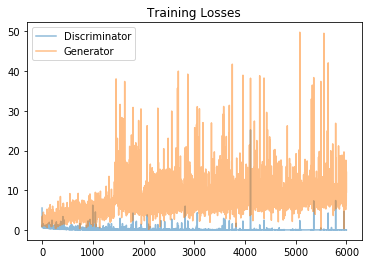

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

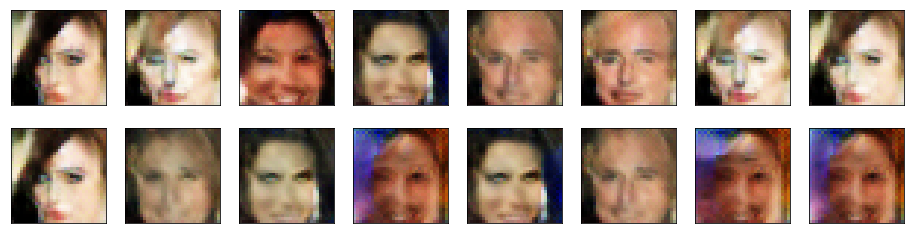

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.